In [28]:
# Importing the Keras libraries and packages
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.preprocessing import image

# Importing other necessary libraries
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import h5py, os, itertools, heapq

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Architecture

In [3]:
# Declaring shape of input images and number of categories to classify
input_shape = (128, 128, 3)
num_classes = 1

model = Sequential()

#convolution layer 1, 2
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#convolution layer 3, 4
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#convolution layer 5, 6
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

#model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.01))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])

In [4]:
# Viewing model_configuration
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
__________

### Image preprocessing

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./dataset/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('./dataset/valid',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5315 images belonging to 2 classes.
Found 592 images belonging to 2 classes.


### Callbacks (save weights while training)

In [6]:
# Setting callbacks parameters
checkpointer = ModelCheckpoint(filepath='model_upper_lower.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
filename='model_upper_lower.csv'
csv_log = CSVLogger(filename, separator=',', append=False)

### Training

In [7]:
# Training the model
hist = model.fit_generator(training_set,
                           steps_per_epoch = (5315//32),
                           epochs = 150,
                           validation_data = test_set,
                           validation_steps = (592//32), 
                           workers = 4, 
                           callbacks = [csv_log, checkpointer])

Epoch 1/150
166/166 [==============================] - 22s 133ms/step - loss: 0.7633 - acc: 0.5946 - val_loss: 0.5990 - val_acc: 0.6632

Epoch 00001: val_loss improved from inf to 0.59899, saving model to model_upper_lower.01-0.60.hdf5
Epoch 2/150
166/166 [==============================] - 17s 101ms/step - loss: 0.6323 - acc: 0.6730 - val_loss: 0.6015 - val_acc: 0.6910

Epoch 00002: val_loss did not improve from 0.59899
Epoch 3/150
166/166 [==============================] - 17s 101ms/step - loss: 0.5374 - acc: 0.7222 - val_loss: 0.4966 - val_acc: 0.7465

Epoch 00003: val_loss improved from 0.59899 to 0.49663, saving model to model_upper_lower.03-0.50.hdf5
Epoch 4/150
166/166 [==============================] - 17s 100ms/step - loss: 0.5130 - acc: 0.7381 - val_loss: 0.4147 - val_acc: 0.7778

Epoch 00004: val_loss improved from 0.49663 to 0.41469, saving model to model_upper_lower.04-0.41.hdf5
Epoch 5/150
166/166 [==============================] - 17s 101ms/step - loss: 0.4682 - acc: 0.76

166/166 [==============================] - 17s 103ms/step - loss: 0.2029 - acc: 0.9177 - val_loss: 0.1682 - val_acc: 0.9358

Epoch 00041: val_loss did not improve from 0.14536
Epoch 42/150
166/166 [==============================] - 17s 103ms/step - loss: 0.2177 - acc: 0.9066 - val_loss: 0.2776 - val_acc: 0.8872

Epoch 00042: val_loss did not improve from 0.14536
Epoch 43/150
166/166 [==============================] - 17s 103ms/step - loss: 0.2104 - acc: 0.9117 - val_loss: 0.1787 - val_acc: 0.9306

Epoch 00043: val_loss did not improve from 0.14536
Epoch 44/150
166/166 [==============================] - 17s 104ms/step - loss: 0.2094 - acc: 0.9132 - val_loss: 0.2500 - val_acc: 0.8941

Epoch 00044: val_loss did not improve from 0.14536
Epoch 45/150
166/166 [==============================] - 17s 104ms/step - loss: 0.1855 - acc: 0.9228 - val_loss: 0.1910 - val_acc: 0.9167

Epoch 00045: val_loss did not improve from 0.14536
Epoch 46/150
166/166 [==============================] - 17s 103ms/st

166/166 [==============================] - 17s 104ms/step - loss: 0.1030 - acc: 0.9607 - val_loss: 0.1369 - val_acc: 0.9479

Epoch 00084: val_loss did not improve from 0.09127
Epoch 85/150
166/166 [==============================] - 17s 102ms/step - loss: 0.1288 - acc: 0.9520 - val_loss: 0.1319 - val_acc: 0.9479

Epoch 00085: val_loss did not improve from 0.09127
Epoch 86/150
166/166 [==============================] - 19s 114ms/step - loss: 0.1203 - acc: 0.9582 - val_loss: 0.1159 - val_acc: 0.9462

Epoch 00086: val_loss did not improve from 0.09127
Epoch 87/150
166/166 [==============================] - 18s 109ms/step - loss: 0.1090 - acc: 0.9595 - val_loss: 0.1132 - val_acc: 0.9583

Epoch 00087: val_loss did not improve from 0.09127
Epoch 88/150
166/166 [==============================] - 17s 104ms/step - loss: 0.0981 - acc: 0.9585 - val_loss: 0.0986 - val_acc: 0.9688

Epoch 00088: val_loss did not improve from 0.09127
Epoch 89/150
166/166 [==============================] - 18s 110ms/st

166/166 [==============================] - 17s 104ms/step - loss: 0.0944 - acc: 0.9637 - val_loss: 0.0876 - val_acc: 0.9618

Epoch 00126: val_loss did not improve from 0.07151
Epoch 127/150
166/166 [==============================] - 17s 104ms/step - loss: 0.1116 - acc: 0.9602 - val_loss: 0.1312 - val_acc: 0.9653

Epoch 00127: val_loss did not improve from 0.07151
Epoch 128/150
166/166 [==============================] - 17s 104ms/step - loss: 0.0819 - acc: 0.9674 - val_loss: 0.0828 - val_acc: 0.9757

Epoch 00128: val_loss did not improve from 0.07151
Epoch 129/150
166/166 [==============================] - 17s 103ms/step - loss: 0.1221 - acc: 0.9559 - val_loss: 0.2574 - val_acc: 0.9253

Epoch 00129: val_loss did not improve from 0.07151
Epoch 130/150
166/166 [==============================] - 17s 104ms/step - loss: 0.0962 - acc: 0.9616 - val_loss: 0.0866 - val_acc: 0.9670

Epoch 00130: val_loss did not improve from 0.07151
Epoch 131/150
166/166 [==============================] - 17s 102

In [20]:
model.save('model1.h5')

### Results

Text(0.5,1,'Training & Validation Accuracy')

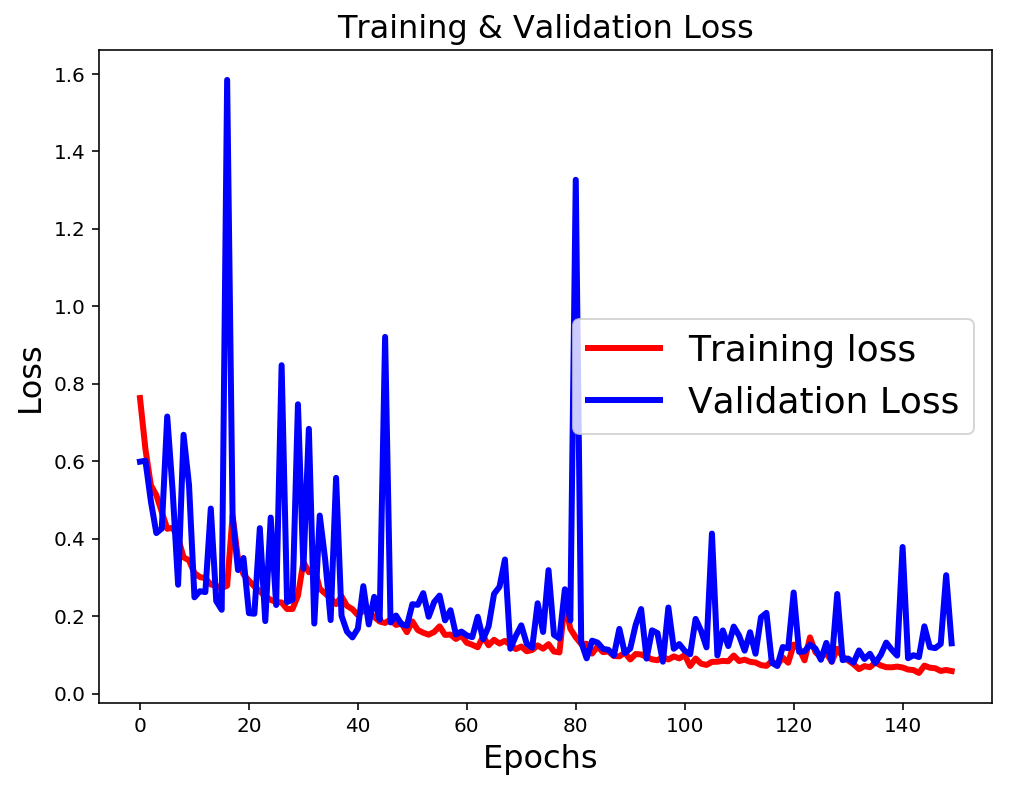

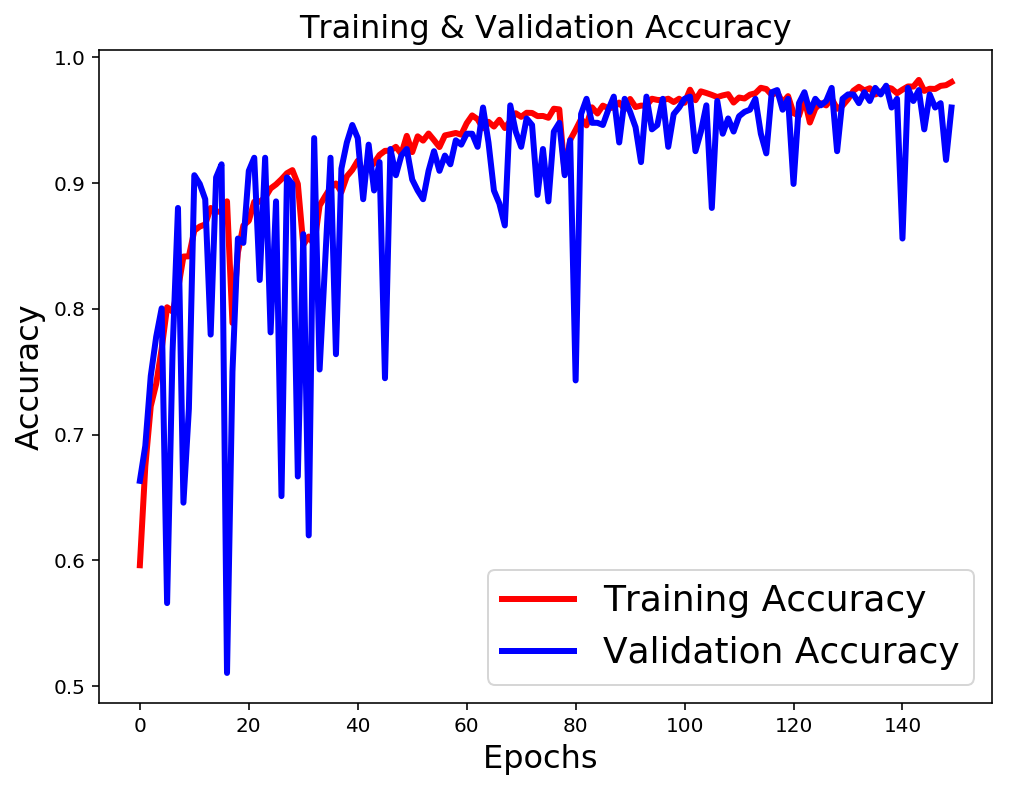

In [8]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Training & Validation Loss',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Training & Validation Accuracy',fontsize=16)

In [15]:
test_path = 'dataset/test'
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['lower','upper'],
                                                                   batch_size = 180)

test_imgs, test_labels = next(test_batches)
batch_pred = model.predict_generator(test_batches, steps=1)

Found 180 images belonging to 2 classes.


In [25]:
# Compute confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1))
np.set_printoptions(precision=1)
cnf_matrix

array([[90,  0],
       [90,  0]], dtype=int64)

Confusion matrix, without normalization
[[90  0]
 [90  0]]


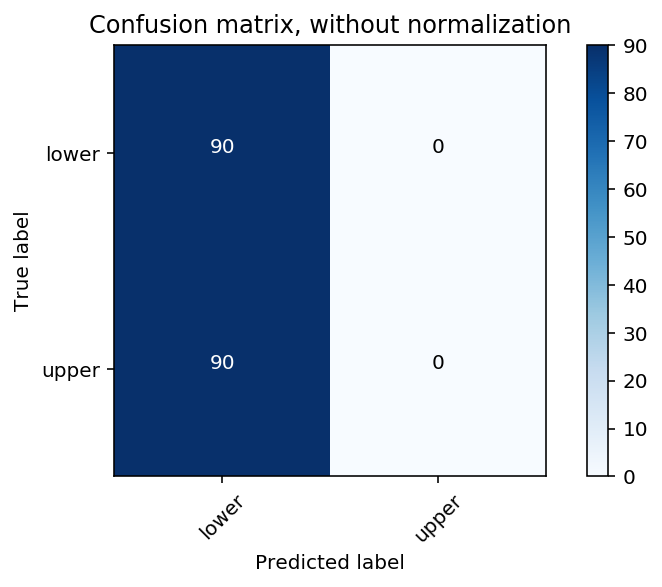

In [26]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['lower','upper'],
                      title='Confusion matrix, without normalization')

In [19]:
classes=['lower','upper']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1),target_names=classes))

             precision    recall  f1-score   support

      lower       0.50      1.00      0.67        90
      upper       0.00      0.00      0.00        90

avg / total       0.25      0.50      0.33       180



c:\users\default.laptop-2ci68m4p\anaconda3\envs\tensorflow1\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Conclusion
####

In [23]:
training_set.class_indices

{'lower': 0, 'upper': 1}

In [24]:
test_batches.class_indices

{'lower': 0, 'upper': 1}

In [83]:
# img = image.load_img('./dataset/test/lower/Acid_Wash_-_Skinny_Jeans_img_00000019.jpg', target_size=(128, 128))
img = image.load_img('./dataset/train/upper/Abstract_Print_Peasant_Blouse_img_00000060.jpg', target_size=(128, 128))

label=['lower','upper']

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

Predict below item is a :  lower


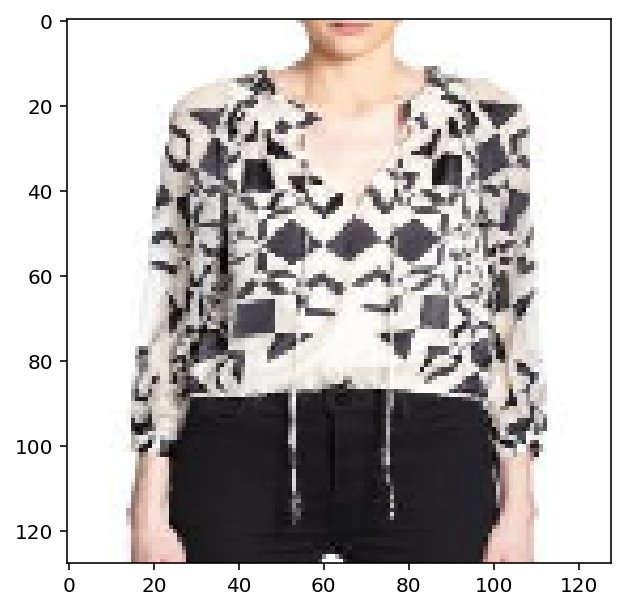

In [84]:
classes = model.predict_classes(images)
plt.figure(figsize=(5,5))
plt.imshow(img)
# plots(images)  
print('Predict below item is a : ', label[classes[0][0]])

In [60]:
classes[0][0]

0

In [85]:
from keras.models import load_model
loaded_model = load_model('./model_upper_lower.118-0.07.hdf5')

In [124]:
img = image.load_img('./dataset/valid/upper/Abstract_Animal_Print_Dress_img_00000040.jpg', target_size=(128, 128))

label=['lower','upper']

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

Predict below item is a :  lower


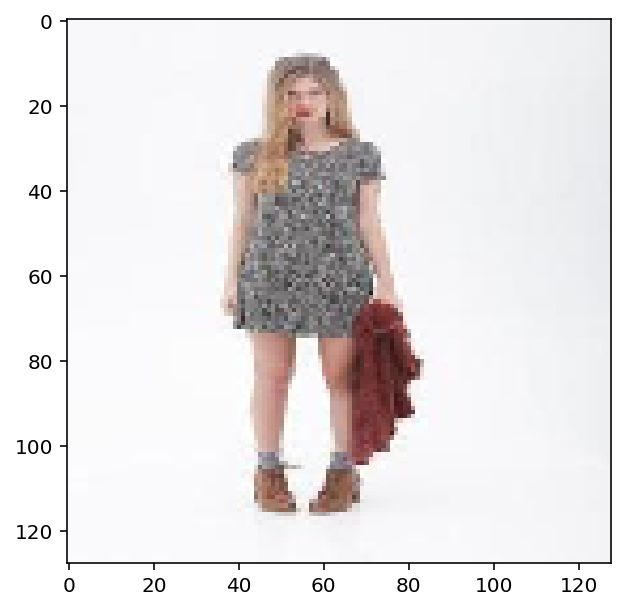

In [125]:
classes = loaded_model.predict_classes(images)
plt.figure(figsize=(5,5))
plt.imshow(img)
# plots(images)  
print('Predict below item is a : ', label[classes[0][0]])